In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/DATA SCIENTIST/P7')

#Librairies

In [ ]:
#Générale
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load 
import pylab as pl
import pickle

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import gc

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
# Training data
app_train = pd.read_csv('application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Testing data features
app_test = pd.read_csv('application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,...,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13976,-1866,-2000.0,-4208,NaN,1,1,0,1,1,0,Sales staff,4.0,2,2,WEDNESDAY,11,0,0,0,0,0,0,Business Entity Type 3,...,0.2446,0.3739,0.0388,0.0817,reg oper account,block of flats,0.3700,Panel,No,0.0,0.0,0.0,0.0,-1805.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010032,-13040,-2191,-4000.0,-4262,16.0,1,1,1,1,0,0,NaN,3.0,2,2,FRIDAY,5,0,0,0,0,1,1,Business Entity Type 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-821.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


#EDA

In [ ]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

% de prêt remboursé


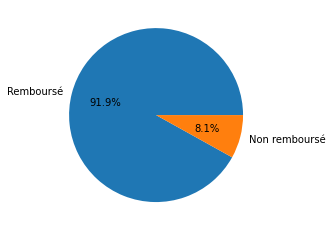

In [ ]:
target_cent_train=app_train['TARGET'].value_counts()/len(app_train)*100

print('% de prêt remboursé')
plt.pie(target_cent_train,
        autopct='%1.1f%%',
        labels=["Remboursé", "Non remboursé"]
           )
plt.show()

In [ ]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [ ]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [ ]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [ ]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [ ]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [ ]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

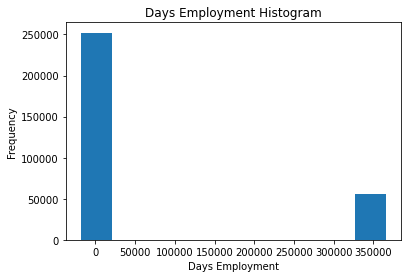

In [ ]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [ ]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


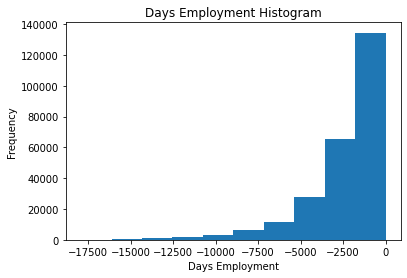

In [ ]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [ ]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


In [ ]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED_ANOM           -0.045987
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645


##Corrélation de pearson

In [ ]:
def heatmap_pearson(frame,v_max,v_min,v_centre):

  final_data_pears=frame.corr(method='pearson')
  #coupe en deux le heatmap
  mask = np.triu(np.ones_like(final_data_pears, dtype=np.bool))
  f, ax = plt.subplots(figsize=(22, 22))

  # couleur
  cmap = sns.diverging_palette(220, 10, as_cmap=True)
  sns.heatmap(final_data_pears, mask=mask, cmap=cmap, vmax=v_max,vmin=v_min, center=v_centre,
              square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

In [ ]:
col_pears=[
 'TARGET',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'OWN_CAR_AGE',
 'REGION_RATING_CLIENT',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3'
]

train_pears=app_train[col_pears].copy()
train_pears.shape

(307511, 19)

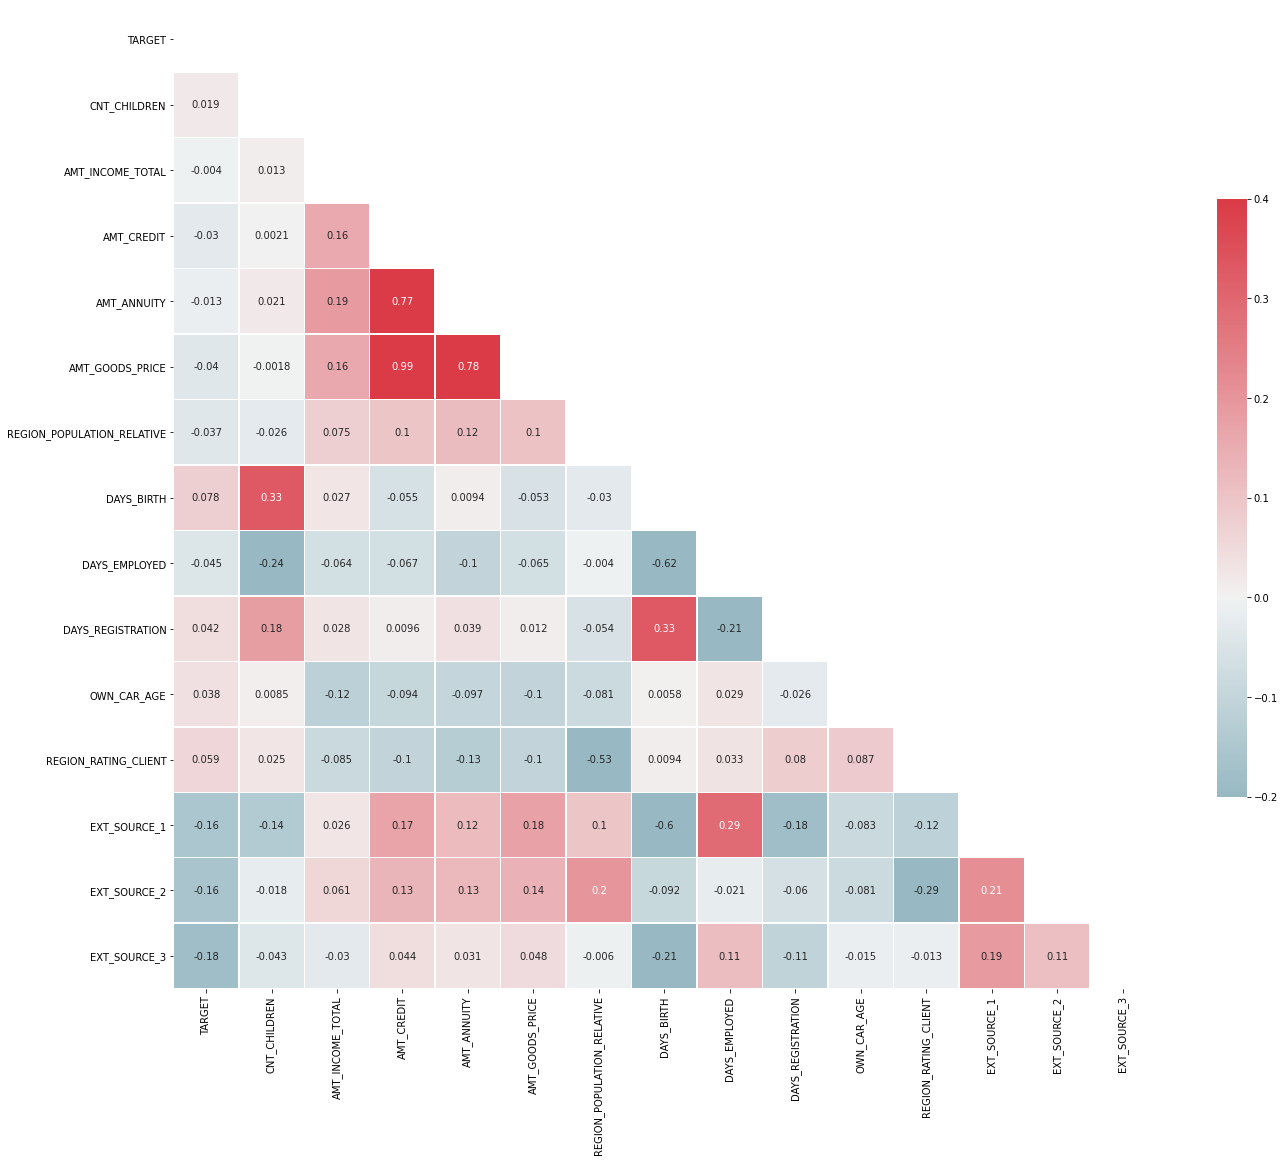

In [ ]:
heatmap_pearson(train_pears,0.4,-0.2,0)

## Effect of Age on Repayment

In [ ]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982694

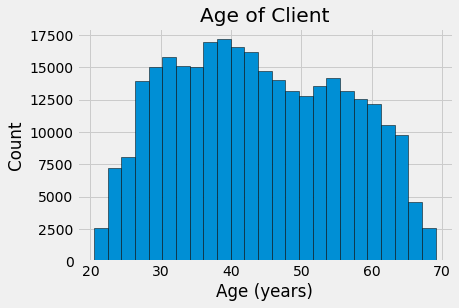

In [ ]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

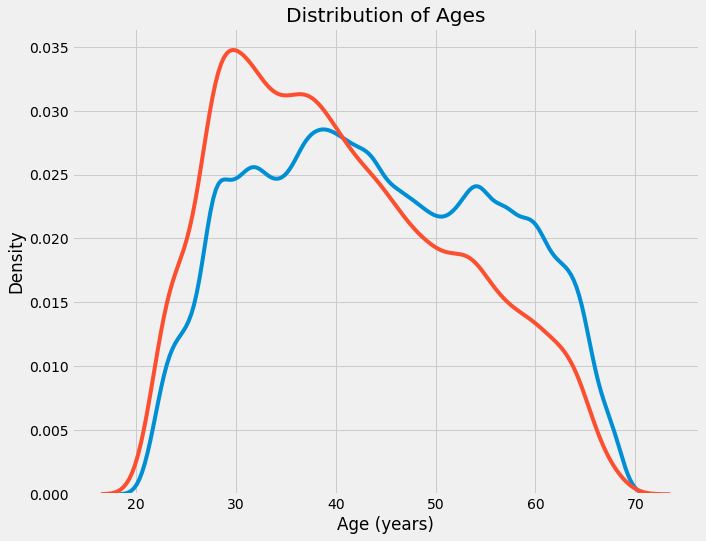

In [ ]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [ ]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [ ]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


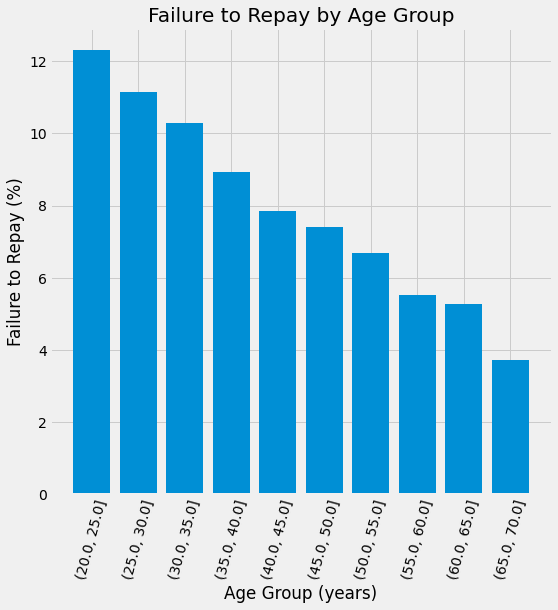

In [ ]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

## Exterior Sources


In [ ]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


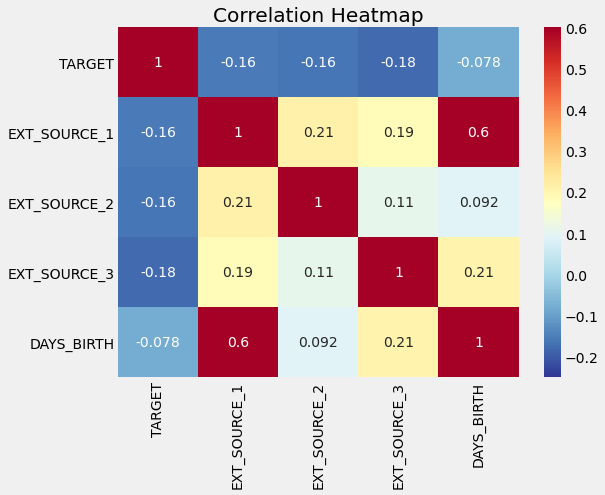

In [ ]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

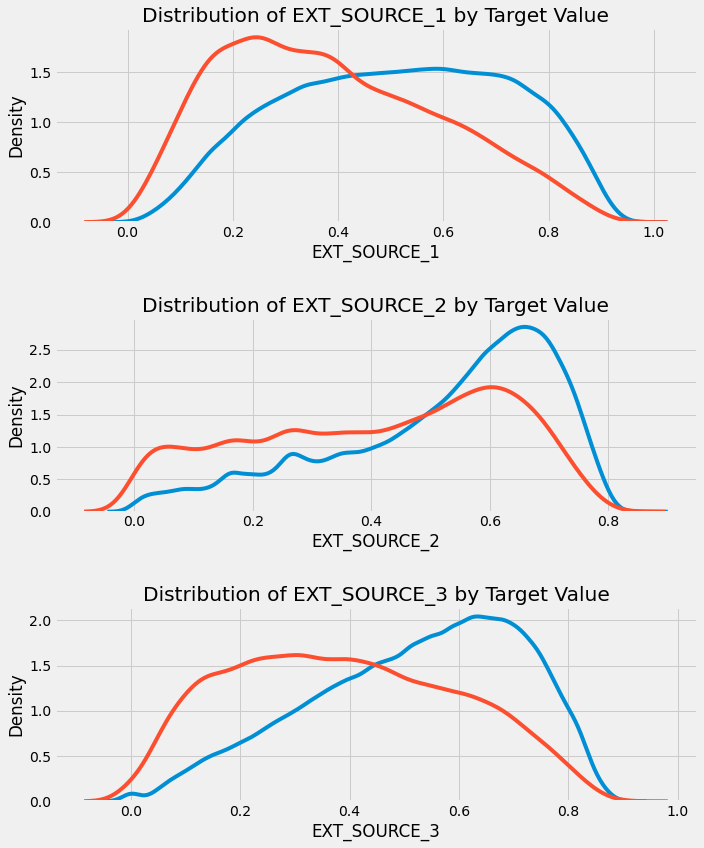

In [ ]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
    

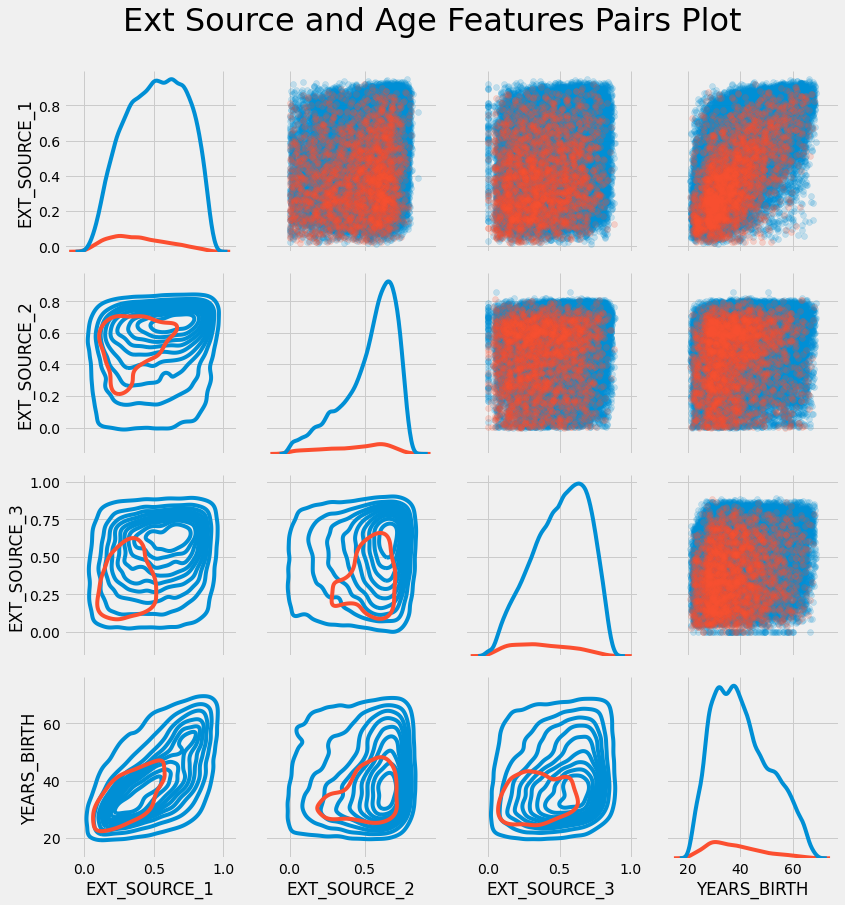

In [ ]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

#Feature Engineering Train et Test

In [ ]:
# Training data
app_train = pd.read_csv('application_train.csv')
print('Training data shape: ', app_train.shape)


# Testing data features
app_test = pd.read_csv('application_test.csv')
print('Testing data shape: ', app_test.shape)


Training data shape:  (307511, 122)
Testing data shape:  (48744, 121)


In [ ]:
### FONCTION POUR NETTOYER ET ENCODER LES DATAS


def clean_data(train, test, encoding = 'ohe'):

    # Valeurs abérantes
    train['DAYS_EMPLOYED_ANOM'] = train["DAYS_EMPLOYED"] == 365243
    test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243

    train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
    test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

    #Création de feature
    app_train_domain = train.copy()
    app_test_domain = test.copy()

    app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
    app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
    app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
    app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

    app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
    app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
    app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
    app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

    features=app_train_domain.copy()
    test_features=app_test_domain.copy()

    # Extraction des ID
    train_ids = features['SK_ID_CURR'] 
    test_ids = test_features['SK_ID_CURR'] 
    
    # Extraction des Targets
    labels = features['TARGET']
   
    # Suppression des ID and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])

    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Alignement des dataframes 
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # label encoding
    elif encoding == 'le':
        
        # Creation du label encoder
        label_encoder = LabelEncoder()
        
        # Liste de stock indices
        cat_indices = []
        
        #Encodage
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                cat_indices.append(i)

    # Extraction des noms des Feature
    feat_name = list(features.columns)

    #Imputation des Nan 
    imputer = SimpleImputer(strategy = 'median')

    features = imputer.fit_transform(features)
    test_features = imputer.transform(test_features)

    # Scale les features
    scaler = MinMaxScaler(feature_range = (0, 1))

    features = scaler.fit_transform(features)
    test_features = scaler.transform(test_features)

    # Création des dataset
    features_set=pd.DataFrame(features,columns=feat_name)
    test_features_set=pd.DataFrame(test_features,columns=feat_name)

    # récupération des ID
    features_set['SK_ID_CURR']=train_ids
    test_features_set['SK_ID_CURR']=test_ids 
    
    # récupération des Targets
    features_set['TARGET']=labels

    print('Training Data Shape: ', features_set.shape)
    print('Testing Data Shape: ', test_features_set.shape)
    
    return features_set, test_features_set



In [ ]:
train_set, test_set= clean_data(app_train, app_test, encoding = 'ohe')

Training Data Shape:  (307511, 248)
Testing Data Shape:  (48744, 247)


In [ ]:
pickle.dump( train_set, open( "set_train.p", "wb" ) )
pickle.dump( test_set, open( "set_test.p", "wb" ) )

In [ ]:
train_set = pickle.load( open( "set_train.p", "rb" ) )
test_set = pickle.load( open( "set_test.p", "rb" ) )

#Modélisation

##Split train validation


In [ ]:
train_set_split, val_set, train_labels, val_labels = train_test_split(train_set.drop('TARGET',axis=1), train_set['TARGET'], test_size = 0.2, random_state = 42)

In [ ]:
train_set_split['TARGET']=train_labels
val_set['TARGET']=val_labels

In [ ]:
train_set_split=train_set_split.reset_index(drop=True)

In [ ]:
print('train shape :',train_set_split.shape)
print('validation shape :',val_set.shape)

train shape : (246008, 248)
validation shape : (61503, 248)


In [ ]:
pickle.dump( train_set_split, open( "train_set_split.p", "wb" ) )
pickle.dump( val_set, open( "val_set.p", "wb" ) )

In [ ]:
train_set_split = pickle.load( open( "train_set_split.p", "rb" ) )
val_set = pickle.load( open( "val_set.p", "rb" ) )

## Optimisation Bayesienne + CV

In [ ]:
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler


def optimisation_baye(set_data,predictor,metric,n_folds = 5,smote=False,under=False,n_ite_baye = 10 ):

  data = set_data.copy()

  # Extraction des ID
  train_ids = data['SK_ID_CURR'] 

  # Extraction des targets
  targets = data['TARGET']
      
  # Remove the ids and target
  data = data.drop(columns = ['SK_ID_CURR', 'TARGET'])

  ### Fonction de cross validation
  def CV_kfol(X,Y,model_classific,metric,seuil_p,n_folds = 5,smote=False,under=False):

    features = X.copy()
    labels = Y.copy()        

    # Extraction des feature names
    feature_names = list(features.columns)
    
    # Convertion en np arrays
    features = np.array(features)        

    # Creation du kfold
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Vecteur vide pour feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Vecteur vide pour prediction sur validation
    prediction = np.zeros(features.shape[0])
    
    # Liste pour stocker les validation et training scores
    valid_scores = []
    
    # Boucle pour chaque fold
    n_boucl=0
    for train_indices, valid_indices in k_fold.split(features):
        n_boucl +=1
        #Avancement
        print('-'*45)
        print('Boucle: {} / {}'.format(n_boucl, n_folds))
        model = model_classific

        # Training data 
        train_features, train_labels = features[train_indices], labels[train_indices]

        #augmentation des data pour meilleurs proportion
        if smote == True :

            sm = SMOTE(random_state=50)
            train_features, train_labels = sm.fit_sample(train_features, train_labels)  

        elif under == True :

            us = RandomUnderSampler(sampling_strategy='majority', random_state=50)
            train_features, train_labels = us.fit_sample(train_features, train_labels)  

        # Validation data 
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]

        # Train du model
        model.fit(train_features, train_labels)
        
        # Récupération du best_iteration
        best_iteration = model.best_iteration_
        
        # Récupération des feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
                  
        # Récupération des predictions des validations 
        prediction[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Evaluation du model avec la metric
        valid_score = metric(labels[valid_indices],prediction[valid_indices],seuil_p)
        print('score de la boucle CV =',valid_score)
        
        # Récupération des best score
        valid_scores.append(valid_score)
        
        # Clean mémoire
        gc.enable()
        del model, train_features, valid_features
        gc.collect()

    return valid_scores#, feature_names, feature_importance_values


  ### Fonction a optimiser
  def optimize_rf(params,
                  model_optim=predictor,
                  X=data,
                  Y=targets,
                  metric=metric,
                  n_folds=n_folds,
                  smote=smote,
                  under=under
                  ):

    params_model = {'n_estimators': int(params['n_estimators']), 
                    'max_depth': int(params['max_depth']), 
                    'learning_rate': params['learning_rate'],
                    'subsample': params['subsample'],
                    'colsample_bytree': params['colsample_bytree'],
                    'num_leaves': int(params['num_leaves']),
                    'reg_alpha': params['reg_alpha'],
                    'reg_lambda': params['reg_lambda'],
    }
    
    model_optim.set_params(**params_model, class_weight = 'balanced')
    seuil_p = params['seuil']

    # Cross validation 
    valid_scor= CV_kfol(X,
                        Y,
                        model_optim,
                        metric,
                        seuil_p,
                        n_folds = n_folds,
                        smote = smote,
                        under = under
                        )
    
    # Moyenne des score de validation
    valid_loss_moy= 1-np.mean(valid_scor)

    print('-'*45)
    print('Perte optim =',valid_loss_moy)
    print('Score optim =',1-valid_loss_moy)
    print('-'*45)
    print('\n')
    print('-'*45)

    return valid_loss_moy


  # espace des parameters
  space={'n_estimators': hp.quniform('n_estimators', 200, 2000, 200),
          'max_depth' : hp.quniform('max_depth', 2, 30, 2),
          'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
          'subsample': hp.quniform('subsample', 0.1, 1.0, 0.2),
          'colsample_bytree': hp.quniform('colsample_by_tree', 0.6, 1.0, 0.1),
          'num_leaves': hp.quniform('num_leaves', 4, 100, 4),
          'reg_alpha': hp.quniform('reg_alpha', 0.1, 1.0, 0.1),
          'reg_lambda': hp.quniform('reg_lambda', 0.1, 1.0, 0.1),
          'seuil': hp.quniform('seuil', 0.0, 1.0, 0.025)
            }

  #Optimisation
  optim=fmin(fn=optimize_rf, 
                space=space, 
                algo=tpe.suggest, # selection des paramètre automatiquement
                max_evals=n_ite_baye, # nb iterations
      )

  # configuration du modèle avec les paramètres optimisés
  predictor.set_params(
                  n_estimators=int(optim['n_estimators']),
                  max_depth=int(optim['max_depth']),
                  learning_rate=optim['learning_rate'],
                  subsample=optim['subsample'],           
                  colsample_bytree=optim['colsample_by_tree'],
                  num_leaves=int(optim['num_leaves']),
                  reg_alpha=optim['reg_alpha'],
                  reg_lambda=optim['reg_lambda']
                    )

  # Entrainement du modèle sur tout le jeux de données 
  predictor.fit(data, targets)

  # Récupération des best parameters
  best_parameters = optim

  # Récupération des feature importances
  feature_importance_values = predictor.feature_importances_

  return best_parameters, feature_importance_values, predictor

##Metrique

In [ ]:
def metric_banq ( y_true, y_pred, seuil=0.5, FN=-100, TP=0, TN=10, FP=-1):

# Liste des prédiction selon un seuil de probabilité
  y_seuil=[]

  for i in y_pred:
    if i >= seuil:
      y_seuil.append(1)
    elif i < seuil:
       y_seuil.append(0)

# Décompte des TP, FP, TN, FN 0 = solvable, 1 = non solvable
  # Matrice de Confusion
  mat_conf = confusion_matrix(y_true, y_seuil)

  fal_neg = mat_conf[1, 0]
  tru_po = mat_conf[1, 1]
  tru_neg = mat_conf[0, 0]  
  fal_po = mat_conf[0, 1]
  
  # Métric bancaire
  ### FN[1,0] ==> perte d'agent pour la banque ==> -100
  ### TP[1,1] ==> refus de prêt ==> 0
  ### TN [0,0] ==> prêt accordé, gain d'argent pour la banque ==> +10
  ### FP[0,1] ==> client perdu, perte d'argent pour la banque ==> -1

  # Gain
  tot = (tru_neg*TN + tru_po*TP + fal_neg*FN + fal_po*FP) 
  max_g = (tru_neg + fal_po)*TN + (tru_po + fal_neg)*TP
  min_g = (tru_neg + fal_po)*FP + (tru_po + fal_neg)*FN
  
  #Normalisation
  gain = (tot - min_g)/(max_g - min_g)

  return gain


## SAMPLING

### Class_weight

In [ ]:
best_parameters_banq2, feature_importance_banq2, pred_model_banq2 = optimisation_baye(train_set_split,
                                                                             LGBMClassifier(),
                                                                             metric=metric_banq,
                                                                             n_ite_baye=15
                                                                             )

---------------------------------------------
Boucle: 1 / 5
score de la boucle CV =
0.5889460303171423
---------------------------------------------
Boucle: 2 / 5
score de la boucle CV =
0.5963515404432326
---------------------------------------------
Boucle: 3 / 5
score de la boucle CV =
0.5891724576412979
---------------------------------------------
Boucle: 4 / 5
score de la boucle CV =
0.5877369178344896
---------------------------------------------
Boucle: 5 / 5
score de la boucle CV =
0.5930121566861773
---------------------------------------------
Perte optim =
0.4089561794155322
Score optim =
0.5910438205844678
---------------------------------------------
---------------------------------------------
---------------------------------------------
Boucle: 1 / 5
score de la boucle CV =
0.5539106350645849
---------------------------------------------
Boucle: 2 / 5
score de la boucle CV =
0.5593278964308255
---------------------------------------------
Boucle: 3 / 5
score de la bou

In [ ]:
pickle.dump(pred_model_banq2, open('pred_model_banq2.md', 'wb'))

In [ ]:
pred_model_banq2 = pickle.load( open( "pred_model_banq2.md", "rb" ) )

In [ ]:
#Feature importances
feat_name=train_set_split.drop(['SK_ID_CURR', 'TARGET'],axis=1).columns
feat_valu=pred_model_banq2.feature_importances_
feat_frame=pd.DataFrame()
feat_frame['feature']=feat_name
feat_frame['importance']=feat_valu

In [ ]:
def plot_feature_importances(df):
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

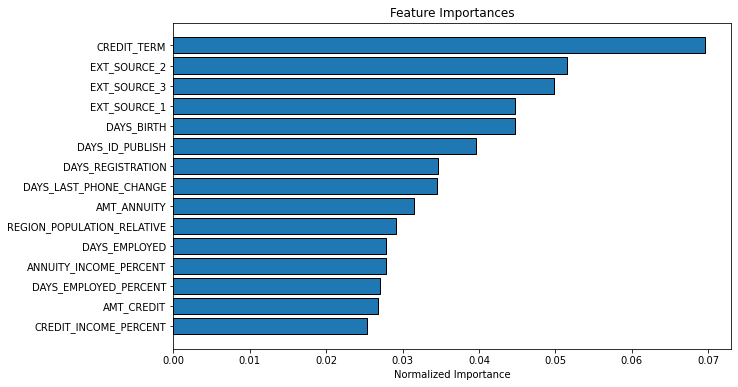

In [ ]:
fi_sorted = plot_feature_importances(feat_frame)

### Seuil probabilité

([<matplotlib.axis.XTick at 0x7f61a4d43f60>,
 <a list of 10 Text major ticklabel objects>)

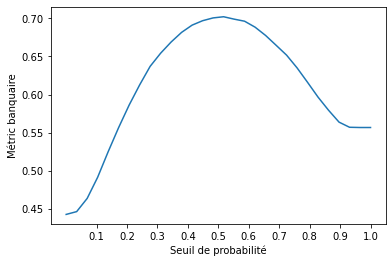

In [ ]:
scor_int = []
int_seuil = np.linspace(0.0, 1, 30)

for s in int_seuil:
    
  # Score du modèle : 0 à 1
  y_scores = pred_model_banq2.predict_proba(val_set.drop(['SK_ID_CURR', 'TARGET'],axis=1))[:, 1]

  y_seuil=[]

  for i in y_scores:
    if i >= s:
      y_seuil.append(1)
    elif i < s:
       y_seuil.append(0)
    
  scor_int.append(metric_banq(val_set['TARGET'], y_seuil))
    
# Affichage du gain en fonction du seuil de solvabilité    
plt.plot(int_seuil, scor_int)
plt.xlabel("Seuil de probabilité")
plt.ylabel("Métric banquaire")
plt.xticks(np.linspace(0.1, 1, 10))

### Over sampling

In [ ]:
best_parameters_banq_smot, feature_importance_banq_smot, pred_model_banq_smot = optimisation_baye(train_set_split,
                                                                             LGBMClassifier(),
                                                                             metric=metric_banq,
                                                                             smote=True,
                                                                             n_ite_baye=15
                                                                             )

---------------------------------------------
Boucle:
1
/
5
score de la boucle CV =
0.566339638449249
---------------------------------------------
Boucle:
2
/
5
score de la boucle CV =
0.5714329030678594
---------------------------------------------
Boucle:
3
/
5
score de la boucle CV =
0.5661063457183969
---------------------------------------------
Boucle:
4
/
5
score de la boucle CV =
0.5617078259095938
---------------------------------------------
Boucle:
5
/
5
score de la boucle CV =
0.5733532192705988
---------------------------------------------
Perte optim =
0.43221201351686034
Score optim =
0.5677879864831397
---------------------------------------------
---------------------------------------------
---------------------------------------------
Boucle:
1
/
5
score de la boucle CV =
0.5667017239727355
---------------------------------------------
Boucle:
2
/
5
score de la boucle CV =
0.5735205927736063
---------------------------------------------
Boucle:
3
/
5
score de la bou

In [ ]:
pickle.dump(pred_model_banq_smot, open('pred_model_banq_smot.md', 'wb'))

In [ ]:
pred_model_banq_smot = pickle.load( open( "pred_model_banq_smot.md", "rb" ) )

### Under sampling

In [ ]:
best_parameters_banq_under, feature_importance_banq_under, pred_model_banq_under = optimisation_baye(train_set_split,
                                                                             LGBMClassifier(),
                                                                             metric=metric_banq,
                                                                             under=True,
                                                                             n_ite_baye=15
                                                                             )

---------------------------------------------
Boucle:
1
/
5
score de la boucle CV =
0.691459683726651
---------------------------------------------
Boucle:
2
/
5
score de la boucle CV =
0.695758811757545
---------------------------------------------
Boucle:
3
/
5
score de la boucle CV =
0.6932549553267672
---------------------------------------------
Boucle:
4
/
5
score de la boucle CV =
0.6910218976483916
---------------------------------------------
Boucle:
5
/
5
score de la boucle CV =
0.6957507879333633
---------------------------------------------
Perte optim =
0.30655077272145637
Score optim =
0.6934492272785436
---------------------------------------------
---------------------------------------------
---------------------------------------------
Boucle:
1
/
5
score de la boucle CV =
0.6967015679974331
---------------------------------------------
Boucle:
2
/
5
score de la boucle CV =
0.6933252326330944
---------------------------------------------
Boucle:
3
/
5
score de la bouc

In [ ]:
pickle.dump(pred_model_banq_under, open('pred_model_banq_under.md', 'wb'))

In [ ]:
pred_model_banq_under = pickle.load( open( "pred_model_banq_under.md", "rb" ) )

### Comparaison sur le set_validation

In [ ]:
#Dic de model:
dict_model_banq={'banq_class_weight':pred_model_banq2,
            'banq_Over_sampling':pred_model_banq_smot,
            'banq_Under_sampling':pred_model_banq_under,
                 }

#Fonction de prédiction sur le set de validation 
def scor_sampling_val (dico_model):
  name_sampl_val=[]
  scor_sampl_val=[]
  target_0=[]
  target_1=[]

  for i,j in dico_model.items():
    y_test_pred_proba=j.predict_proba(val_set.drop(['SK_ID_CURR', 'TARGET'],axis=1))[:, 1]
    name_sampl_val.append(i)
    scor_sampl_val.append(metric_banq(val_set['TARGET'],y_test_pred_proba))

    seuil=0.52 
    y_seuil_test=[]
    for i in y_test_pred_proba:
      if i >= seuil:
        y_seuil_test.append(1)
      elif i < seuil:
          y_seuil_test.append(0)

    pred_frame=pd.DataFrame(y_seuil_test)
    target_0.append((pred_frame.value_counts()/len(pred_frame)*100)[0].item())
    target_1.append((pred_frame.value_counts()/len(pred_frame)*100)[1].item())
   
  return name_sampl_val,scor_sampl_val,target_0,target_1

name_sampl_val_banq,scor_sampl_val_banq,target_0,target_1=scor_sampling_val(dict_model_banq)

#Tableau récap des scores
Scor_fram=pd.DataFrame()
Scor_fram['Sampling_banq']=name_sampl_val_banq
Scor_fram['score_banq']=scor_sampl_val_banq
Scor_fram['Pred_0']=target_0
Scor_fram['Pred_1']=target_1
Scor_fram

,Sampling_banq,score_banq,Pred_0,Pred_1
0,banq_class_weight,0.702709,74.521568,25.478432
1,banq_Over_sampling,0.670246,86.709591,13.290409
2,banq_Under_sampling,0.696331,70.188446,29.811554


In [ ]:
val_frame_comp=Scor_fram.copy()
val_frame_comp['score_banq']=val_frame_comp['score_banq']*100
val_list={'Sampling_banq':'True_val','Pred_0':(val_set['TARGET'].value_counts()/len(val_set)*100)[0].item(),'Pred_1':(val_set['TARGET'].value_counts()/len(val_set)*100)[1].item()}
val_frame_comp=val_frame_comp.append(val_list,ignore_index=True)
val_frame_comp=val_frame_comp.set_index(val_frame_comp['Sampling_banq']).drop('Sampling_banq',axis=1)
val_frame_comp

,score_banq,Pred_0,Pred_1
Sampling_banq,,,
banq_class_weight,70.270924,74.521568,25.478432
banq_Over_sampling,67.024621,86.709591,13.290409
banq_Under_sampling,69.633051,70.188446,29.811554
True_val,NaN,91.953238,8.046762


<Figure size 1440x1440 with 0 Axes>

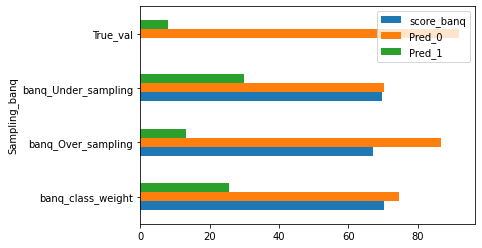

In [ ]:
val_frame_comp.plot.barh()


#Prédiction sur le Test

In [ ]:
pred_model_banq2.get_params

<bound method LGBMModel.get_params of LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split',
               learning_rate=0.011145482490471455, max_depth=14,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1800, n_jobs=-1, num_leaves=60, objective=None,
               random_state=None, reg_alpha=0.4, reg_lambda=0.1, silent=True,
               subsample=0.8, subsample_for_bin=200000, subsample_freq=0)>

In [ ]:
y_test_pred_proba=pred_model_banq2.predict_proba(test_set.drop(['SK_ID_CURR'],axis=1))[:, 1]

seuil=0.52 
y_seuil_test=[]

for i in y_test_pred_proba:
  if i >= seuil:
    y_seuil_test.append(1)
  elif i < seuil:
      y_seuil_test.append(0)

pred_frame=test_set.copy()
pred_frame['Proba']=y_test_pred_proba
pred_frame['TARGET']=y_seuil_test
pred_frame.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,...,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,SK_ID_CURR,Proba,TARGET
0,0.000000,0.000935,0.130787,0.073886,0.102132,0.257000,0.337542,0.869975,0.790451,0.887175,0.098901,1.0,1.0,0.0,1.0,0.0,1.0,0.052632,0.5,0.5,0.782609,0.0,0.0,0.0,0.0,0.0,0.0,0.778428,0.923573,0.177549,0.0660,0.0590,0.9732,0.7552,0.0211,0.00,0.1379,0.1250,0.2083,0.0481,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,100001,0.228842,0
1,0.000000,0.000627,0.044387,0.061443,0.034792,0.491595,0.403890,0.750502,0.630431,0.774489,0.098901,1.0,1.0,0.0,1.0,0.0,0.0,0.052632,0.5,0.5,0.391304,0.0,0.0,0.0,0.0,0.0,0.0,0.580538,0.341118,0.482907,0.0876,0.0763,0.9816,0.7552,0.0211,0.00,0.1379,0.1667,0.2083,0.0481,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100005,0.609141,1
2,0.000000,0.001512,0.154373,0.265830,0.147026,0.260475,0.292616,0.751117,0.911843,0.513269,0.054945,1.0,1.0,0.0,1.0,0.0,0.0,0.052632,0.5,0.5,0.608696,0.0,0.0,0.0,0.0,0.0,0.0,0.518318,0.818464,0.681715,0.0876,0.0763,0.9816,0.7552,0.0211,0.00,0.1379,0.1667,0.2083,0.0481,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100013,0.174548,0
3,0.105263,0.002474,0.382022,0.184872,0.382716,0.361433,0.634329,0.895824,0.918936,0.415312,0.098901,1.0,1.0,0.0,1.0,1.0,0.0,0.157895,0.5,0.5,0.478261,0.0,0.0,0.0,0.0,0.0,0.0,0.539134,0.596114,0.683628,0.3052,0.1974,0.9970,0.9592,0.1165,0.32,0.2759,0.3750,0.0417,0.2042,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,100028,0.194468,0
4,0.052632,0.001320,0.144944,0.118761,0.145903,0.134897,0.687091,0.877680,0.837873,0.407809,0.175824,1.0,1.0,1.0,1.0,0.0,0.0,0.105263,0.5,0.5,0.217391,0.0,0.0,0.0,0.0,1.0,1.0,0.197840,0.497880,0.597163,0.0876,0.0763,0.9816,0.7552,0.0211,0.00,0.1379,0.1667,0.2083,0.0481,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

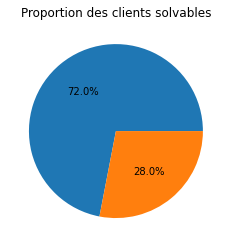

In [ ]:
plt.title("Proportion des clients solvables")
plt.pie(pred_frame["TARGET"].value_counts(),
       autopct='%1.1f%%',
       radius=1)
plt.show()

In [ ]:
pred_frame.to_csv('pred_frame.csv')

In [ ]:
pred_frame=pd.read_csv('pred_frame.csv').drop('Unnamed: 0',axis=1)

#Interpretation

##Préparation du set pour Dashboard

In [ ]:
pred_model_banq2 = pickle.load( open( "pred_model_banq2.md", "rb" ) )

In [ ]:
val_set = pickle.load( open( "val_set.p", "rb" ) )

In [ ]:
y_test_pred_proba=pred_model_banq2.predict_proba(val_set.drop(['SK_ID_CURR','TARGET'],axis=1))[:, 1]

seuil=0.52 
y_seuil_test=[]

for i in y_test_pred_proba:
  if i >= seuil:
    y_seuil_test.append(1)
  elif i < seuil:
      y_seuil_test.append(0)

pred_frame_dash=val_set.copy()
pred_frame_dash['Proba']=y_test_pred_proba
pred_frame_dash['PREDICTION']=y_seuil_test
pred_frame_dash.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,...,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,SK_ID_CURR,TARGET,Proba,PREDICTION
245895,0.105263,0.001550,0.104983,0.199000,0.094276,0.129331,0.672604,0.957459,0.974181,0.401556,0.208791,1.0,1.0,0.0,1.0,0.0,0.0,0.157895,0.5,0.5,0.478261,0.0,0.0,0.0,0.0,1.0,1.0,0.697493,0.707479,0.000000,0.0876,0.0763,0.9816,0.7552,0.0211,0.00,0.1379,0.1667,0.2083,0.0481,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,384575,0,0.499929,0
98194,0.000000,0.001897,0.308792,0.184591,0.283951,0.090864,0.589121,0.936300,0.934744,0.368348,0.120879,1.0,1.0,0.0,1.0,0.0,1.0,0.000000,1.0,1.0,0.434783,0.0,0.0,0.0,0.0,0.0,0.0,0.439034,0.497486,0.794687,0.0753,0.0568,0.9970,0.9592,0.1326,0.08,0.0517,0.4167,0.2917,0.0735,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,214010,0,0.185594,0
36463,0.000000,0.001512,0.112360,0.146227,0.113356,0.491595,0.412740,0.964326,0.898387,0.796999,0.043956,1.0,1.0,1.0,1.0,0.0,0.0,0.052632,0.5,0.5,0.695652,0.0,0.0,0.0,0.0,0.0,0.0,0.540721,0.621942,0.231648,0.0876,0.0763,0.9816,0.7552,0.0211,0.00,0.1379,0.1667,0.2083,0.0481,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,142232,0,0.748607,1
249923,0.000000,0.001897,0.052360,0.090962,0.046016,0.635991,0.315840,0.610205,0.547382,0.561206,0.098901,1.0,1.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.608696,0.0,0.0,0.0,0.0,0.0,0.0,0.518318,0.811136,0.685538,0.1320,0.0645,0.9846,0.7552,0.0211,0.16,0.0690,0.6250,0.2083,0.0481,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,389171,0,0.053448,0
158389,0.000000,0.000742,0.065701,0.055563,0.048260,0.257000,0.276325,0.938310,0.704159,0.931360,0.098901,1.0,1.0,0.0,1.0,0.0,0.0,0.000000,0.5,0.5,0.478261,0.0,0.0,0.0,0.0,0.0,0.0,0.675347,0.655778,0.710063,0.0619,0.0553,0.9717,0.7552,0.0211,0.00,0.1724,0.1667,0.2083,0.0866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

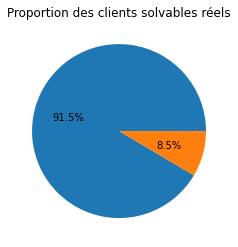

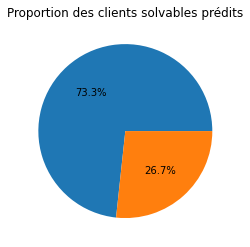

In [ ]:
#Réduction de la taille du data set

pred_frame_dash_s1000=pred_frame_dash.sample(1000,random_state=42)
plt.title("Proportion des clients solvables réels")
plt.pie(pred_frame_dash_s1000["TARGET"].value_counts(),
       autopct='%1.1f%%',
       radius=1)
plt.show()
plt.title("Proportion des clients solvables prédits")
plt.pie(pred_frame_dash_s1000["PREDICTION"].value_counts(),
       autopct='%1.1f%%',
       radius=1)
plt.show()

In [ ]:
pickle.dump(pred_frame_dash_s1000, open( "pred_frame_dash_s1000.p", "wb" ) )

In [ ]:
pred_frame_dash_s1000 = pickle.load( open( "pred_frame_dash_s1000.p", "rb" ) )

In [ ]:
pred_frame_dash_s1000.shape

(1000, 250)

## Shap

In [ ]:
pip install shap

     |████████████████████████████████| 358kB 13.5MB/s 
  Created wheel for shap: filename=shap-0.38.1-cp36-cp36m-linux_x86_64.whl size=489395 sha256=d181e2b6c6eaf69e291d744ec1aa38057c7c72cdb30fe889b7ac80bb6e1b1b1c
  Stored in directory: /root/.cache/pip/wheels/a8/fb/e4/88012be41842b9be62ae18d82d1b1e880daf8539d1fef1fa00
Successfully built shap


In [ ]:
import shap

In [ ]:
ID_client=pred_frame_dash_s1000['SK_ID_CURR']

X_ID=pred_frame_dash_s1000[pred_frame_dash_s1000['SK_ID_CURR']==ID_client].copy()
X_ID=X_ID.reset_index(drop=True)
X=X_ID.drop(['SK_ID_CURR','Proba', 'TARGET','PREDICTION'],axis=1)
y_ID=X_ID['SK_ID_CURR']
y_Target=X_ID['TARGET']
y_proba=X_ID['Proba']
y_pred=X_ID['PREDICTION']


explainer = shap.TreeExplainer(pred_model_banq2)
shap_values = explainer.shap_values(X)

In [ ]:
pickle.dump(shap_values, open( "shap_values.p", "wb" ) )

In [ ]:
shap_values = pickle.load( open( "shap_values.p", "rb" ) )

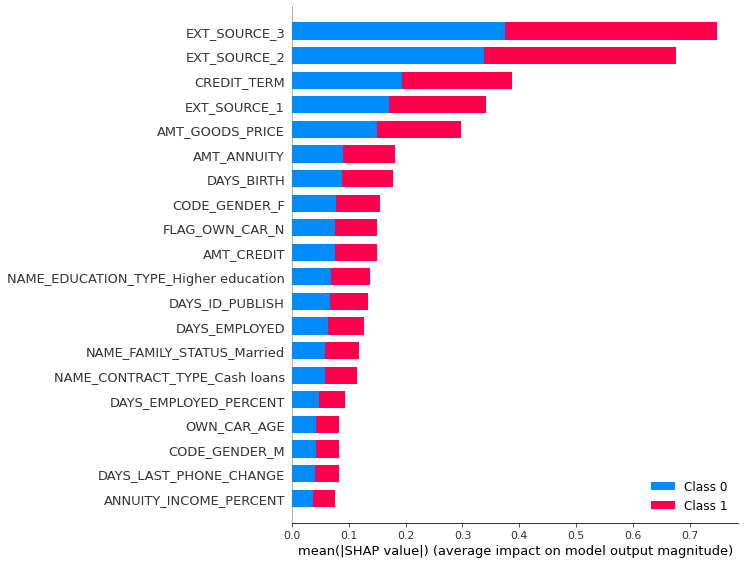

In [ ]:
shap.summary_plot(shap_values, X)

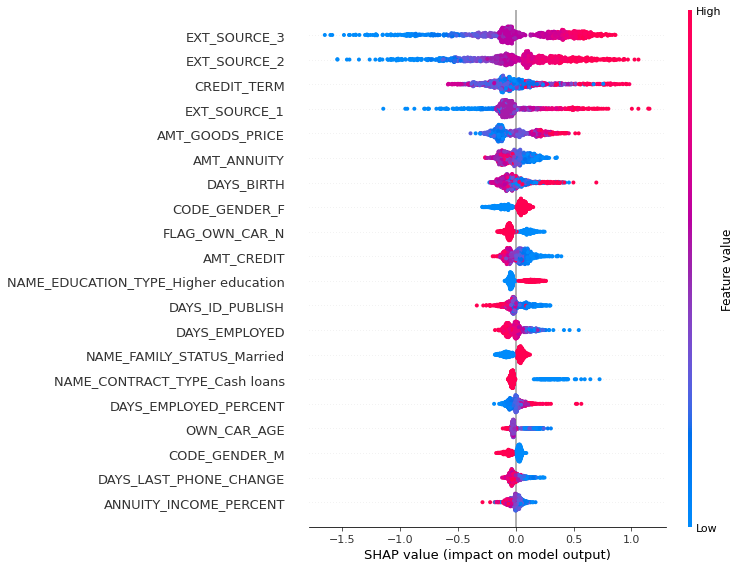

In [ ]:
shap.summary_plot(shap_values[0], X)

In [ ]:
## Client solvable 0
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][1,:], X.iloc[1,:])

In [ ]:
## Client non solvable 1
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X.iloc[0,:])

In [ ]:
### Frame avec les SHap values
set_shap=pd.DataFrame(shap_values[1],columns=X.columns)
set_shap['SK_ID_CURR']=y_ID
set_shap['TARGET']=y_Target
set_shap['Proba']=y_proba
set_shap['PREDICTION']=y_pred
set_shap.head(3)

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,...,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,SK_ID_CURR,TARGET,Proba,PREDICTION
0,0.002029,0.007412,0.074330,0.151873,-0.215251,-0.015511,0.081458,0.065698,0.000339,-0.102671,0.020778,0.0,0.000141,-0.012338,0.0,0.007976,0.000202,-0.004013,-0.001717,-0.005953,0.014997,0.000729,0.000876,0.000169,-0.010719,0.004879,-0.003552,0.107242,0.654335,0.541220,0.000680,0.002941,0.001344,0.000644,0.001409,0.001222,0.001693,0.005605,-0.001199,0.000841,...,-0.000056,0.003935,0.000042,0.003422,-0.005667,-4.241454e-07,-0.000004,0.0,0.000864,-0.000007,0.000071,0.000025,0.000500,0.000005,0.0,-0.000033,-0.001093,-0.000104,0.000188,-0.000436,-0.000305,0.000254,-0.000751,0.000501,0.000099,-0.000044,0.000007,0.000137,-0.000025,0.000839,-0.000200,0.005385,-0.000918,0.000032,0.000751,0.000005,407405,1,0.744702,1
1,0.001412,0.037297,0.099124,0.105057,-0.225605,0.051559,-0.001373,0.013911,0.009191,0.012211,0.016311,0.0,0.000879,0.001860,0.0,0.006899,0.000425,-0.002714,0.002324,0.000934,0.004544,0.000539,0.003319,0.000250,-0.006184,-0.000259,0.000310,0.061125,0.105368,0.165148,-0.009601,-0.010251,-0.010806,-0.018965,-0.037113,-0.011320,-0.028036,-0.032295,0.000699,0.002965,...,-0.000088,0.006699,0.000036,0.002617,0.001846,3.657833e-05,-0.000006,0.0,0.001182,-0.000038,0.000071,0.000025,0.000270,0.000008,0.0,0.000020,-0.000567,-0.000031,0.000073,0.003102,-0.000448,0.000009,-0.000997,-0.015075,-0.000786,-0.000007,0.000006,0.000086,-0.000080,0.000218,0.000249,0.006316,0.009713,0.000026,-0.002062,-0.000002,336258,0,0.352118,0
2,0.001420,0.005879,0.043069,-0.038931,0.181368,-0.039398,0.106613,-0.114079,0.032557,-0.093904,0.022403,0.0,0.000035,0.071218,0.0,-0.019923,-0.000260,0.006719,-0.003233,-0.025726,0.016936,0.000868,0.000313,0.000147,-0.014086,-0.000456,0.000471,0.101345,1.540831,-0.290668,0.001208,0.005982,0.000930,0.001385,0.000053,0.001397,0.000902,0.004175,-0.000834,0.000580,...,-0.000118,0.001504,0.000237,0.002791,-0.004418,1.778152e-05,-0.000005,0.0,0.001195,0.000288,0.000071,0.000025,0.000501,0.000002,0.0,0.000007,-0.000846,-0.000151,0.000101,-0.000749,0.000025,0.000025,-0.000092,0.000791,-0.000100,0.000005,0.000008,0.000060,-0.000060,0.000722,-0.000157,0.006816,-0.002758,0.000717,0.001454,0.000038,448283,0,0.695634,1


In [ ]:
pickle.dump(set_shap, open( "set_shap.p", "wb" ) )

In [ ]:
set_shap = pickle.load( open( "set_shap.p", "rb" ) )

##Comparaison global

In [ ]:
#Comparaison d'un client sur l'ensemble du set (moyenne)

def plot_ft_global(ID,frame_shap):
  id_num=ID
  ### Récupération des feat. les plus importants pour le client
  set_shap_id=frame_shap[frame_shap['SK_ID_CURR']==id_num].copy().T
  set_shap_id=set_shap_id.rename({frame_shap[frame_shap["SK_ID_CURR"]==id_num].index.item(): 'valeur'}, axis=1)
  set_shap_id=set_shap_id.drop(['SK_ID_CURR','Proba', 'TARGET','PREDICTION'],axis=0).sort_values(by='valeur')
  
  ft_ID_0=[]
  ft_ID_index_0=[]
  ft_ID_1=[]
  ft_ID_index_1=[]

  ft_ID_1.append(set_shap_id['valeur'][0])
  ft_ID_index_1.append(set_shap_id[set_shap_id['valeur']==ft_ID_1[0]].index.item())
  ft_ID_1.append(set_shap_id['valeur'][1])
  ft_ID_index_1.append(set_shap_id[set_shap_id['valeur']==ft_ID_1[1]].index.item())

  ft_ID_0.append(set_shap_id['valeur'][-1])
  ft_ID_index_0.append(set_shap_id[set_shap_id['valeur']==ft_ID_0[0]].index.item())
  ft_ID_0.append(set_shap_id['valeur'][-2])
  ft_ID_index_0.append(set_shap_id[set_shap_id['valeur']==ft_ID_0[1]].index.item())

  #Feat augmentant le risque

  #calcul des moyennes global pour les feat. les plus importants
  ft_moy_glob=[]
  ft_moy_0=[]
  ft_moy_1=[]
  ft_glob_index=[]

  for ft in ft_ID_index_1:
    ft_glob_index.append(ft)
    #moy global
    ft_moy_glob.append(frame_shap[ft].mean())
    #moy sur les client solvable
    ft_moy_0.append(frame_shap[frame_shap['TARGET']==0][ft].mean())
    #moy sur les client non solvable
    ft_moy_1.append(frame_shap[frame_shap['TARGET']==1][ft].mean())

  set_ft_glob=pd.DataFrame()
  set_ft_glob['feature']=ft_glob_index
  set_ft_glob['moy_global']=ft_moy_glob
  set_ft_glob['moy_0']=ft_moy_0
  set_ft_glob['moy_1']=ft_moy_1
  set_ft_glob['ID:'+str(id_num)]=ft_ID_1
  set_ft_glob=set_ft_glob.set_index(set_ft_glob['feature']).T.drop('feature')
  
  print('Comparaison des infos du client pour les features augmentant le risque')
  for ft in set_ft_glob.columns:
    print(ft)
    sns.barplot(y = set_ft_glob[ft].index,x=set_ft_glob[ft])
    plt.show()

  #feat diminuant le risque

  #calcul des moyennes global pour les feat. les plus importants
  ft_moy_glob=[]
  ft_moy_0=[]
  ft_moy_1=[]
  ft_glob_index=[]

  for ft in ft_ID_index_0:
    ft_glob_index.append(ft)
    #moy global
    ft_moy_glob.append(frame_shap[ft].mean())
    #moy sur les client solvable
    ft_moy_0.append(frame_shap[frame_shap['TARGET']==0][ft].mean())
    #moy sur les client non solvable
    ft_moy_1.append(frame_shap[frame_shap['TARGET']==1][ft].mean())

  set_ft_glob_0=pd.DataFrame()
  set_ft_glob_0['feature']=ft_glob_index
  set_ft_glob_0['moy_global']=ft_moy_glob
  set_ft_glob_0['moy_0']=ft_moy_0
  set_ft_glob_0['moy_1']=ft_moy_1
  set_ft_glob_0['ID:'+str(id_num)]=ft_ID_0
  set_ft_glob_0=set_ft_glob_0.set_index(set_ft_glob_0['feature']).T.drop('feature')

  print('Comparaison des infos du client pour les features diminuant le risque')
  for ft in set_ft_glob_0.columns:
    print(ft)
    sns.barplot(x = set_ft_glob_0[ft].index,y=set_ft_glob_0[ft])
    plt.show()


  return set_ft_glob,set_ft_glob_0

Comparaison des infos du client pour les features augmentant le risque
AMT_GOODS_PRICE


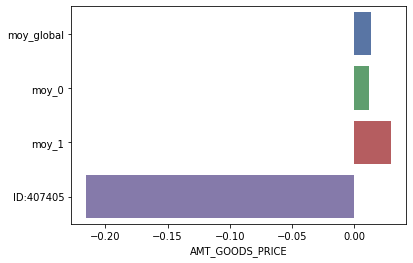

FLAG_OWN_CAR_N


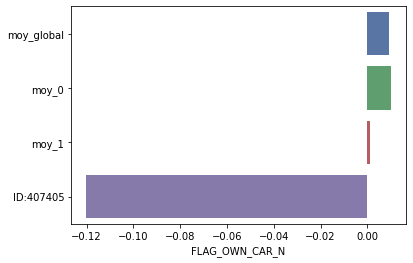

Comparaison des infos du client pour les features diminuant le risque
EXT_SOURCE_2


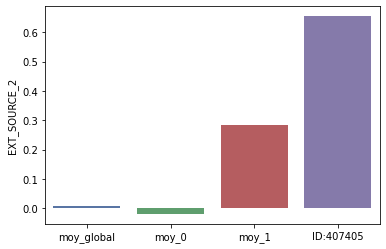

EXT_SOURCE_3


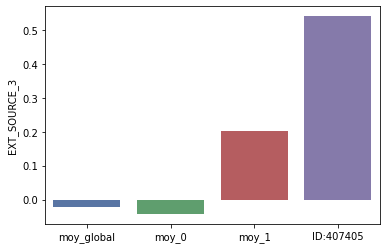

(feature    AMT_GOODS_PRICE FLAG_OWN_CAR_N
 moy_global       0.0135816     0.00928198
 moy_0            0.0121166      0.0100216
 moy_1             0.029352     0.00131986
 ID:407405        -0.215251      -0.120108,
 feature    EXT_SOURCE_2 EXT_SOURCE_3
 moy_global   0.00566136   -0.0220821
 moy_0        -0.0200068   -0.0428146
 moy_1          0.281971     0.201097
 ID:407405      0.654335      0.54122)

In [ ]:
plot_ft_global(407405, set_shap)

In [ ]:
### Sampling du app_train pour récupérer vrai valeur
tru_data=[]
for i in list(set_shap['SK_ID_CURR']):
  tru_data.append(app_train.iloc[app_train[app_train['SK_ID_CURR']==i].index.item(),:])

set_tru_data=pd.DataFrame(tru_data)
set_tru_data

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
265413,407405,1,Cash loans,M,Y,Y,1,180000.0,1288350.0,37800.0,1125000.0,Family,Working,Secondary / secondary special,Married,House / apartment,0.008019,-15962,-759,-8337.0,-4960,13.0,1,1,0,1,0,0,Laborers,3.0,2,2,TUESDAY,15,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,2.0,0.0,3.0
203790,336258,0,Cash loans,F,N,Y,0,261000.0,1436850.0,46350.0,1125000.0,Unaccompanied,Pensioner,Higher education,Married,House / apartment,0.020713,-20271,365243,-3283.0,-3302,NaN,1,0,0,1,0,0,NaN,2.0,3,2,TUESDAY,10,0,0,0,0,0,0,...,0.3711,0.4843,0.0039,0.0009,reg oper spec account,block of flats,0.4980,"Stone, brick",No,2.0,0.0,2.0,0.0,-232.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
300626,448283,0,Cash loans,F,N,Y,0,85050.0,545040.0,20677.5,450000.0,Family,Working,Secondary / secondary special,Married,House / apartment,0.007020,-15636,-5378,-6109.0,-4430,NaN,1,1,1,1,1,0,Cooking staff,2.0,2,2,MONDAY,12,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-305.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
200238,332126,0,Cash loans,F,N,Y,0,81000.0,598486.5,21627.0,454500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.020713,-15158,-4370,-9104.0,-4843,NaN,1,1,0,1,0,0,Cleaning staff,2.0,3,2,TUESDAY,12,0,0,0,0,0,0,...,0.0684,0.0724,0.0000,0.0000,reg oper account,block of flats,0.0559,Panel,No,2.0,0.0,2.0,0.0,-1767.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,2.0,1.0
192250,322924,0,Cash loans,F,N,Y,0,112500.0,1178703.0,82165.5,1129500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.022625,-12557,-773,-5214.0,-2652,NaN,1,1,0,1,0,0,Sales staff,2.0,2,2,TUESDAY,12,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,-1180.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188756,318838,0,Cash loans,M,N,N,1,225000.0,508495.5,24462.0,454500.0,Family,Working,Secondary / secondary special,Married,House / apartment,0.009630,-16560,-2072,-283.0,-117,NaN,1,1,0,1,1,0,Laborers,3.0,2,2,SATURDAY,13,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [ ]:
pickle.dump(set_tru_data, open( "set_tru_data.p", "wb" ) )

In [ ]:
#Comparaison d'un client sur l'ensemble du set (distribution)

def hist_plot_global(ID,frame_shap,frame_cl):
  id_num=int(ID)
  ### Récupération des feat. les plus importants pour le client
  set_shap_id=frame_shap[frame_shap['SK_ID_CURR']==id_num].copy().T
  set_shap_id=set_shap_id.rename({frame_shap[frame_shap["SK_ID_CURR"]==id_num].index.item(): 'valeur'}, axis=1)
  set_shap_id=set_shap_id.drop(['SK_ID_CURR','Proba', 'TARGET','PREDICTION'],axis=0).sort_values(by='valeur')

  ft_ID_0=[]
  ft_ID_1=[]


  ft_ID_1.append(set_shap_id.index[0])
  ft_ID_1.append(set_shap_id.index[1])

  ft_ID_0.append(set_shap_id.index[-1])
  ft_ID_0.append(set_shap_id.index[-2])

  #Feat augmentant le risque

  #calcul des moyennes global pour les feat. les plus importants
  ft_moy_glob=[]
  ft_moy_0=[]
  ft_moy_1=[]
  ft_glob_index=[]
  ft_cl=[]
  print('Comparaison des infos du client pour les features augmentant le risque')
  for ft in ft_ID_1:
    print(ft)
    
    plt.style.use('seaborn-deep')

    x = frame_cl[frame_cl['TARGET']==0][ft]
    y = frame_cl[frame_cl['TARGET']==1][ft]
    z = frame_cl[ft]
    bins = np.linspace(0, 1, 10)

    risque_client=frame_cl[frame_cl['SK_ID_CURR']==id_num][ft].item()

    plt.hist([x, y,z], bins, label=['Solvable', 'Non solvable','Global'])
    plt.axvline(risque_client,linewidth=4, color='#28dbef')

    plt.legend(loc='upper right')
    plt.ylabel('Nb de client')
    plt.show()

  #feat diminuant le risque

  #calcul des moyennes global pour les feat. les plus importants
  ft_moy_glob=[]
  ft_moy_0=[]
  ft_moy_1=[]
  ft_glob_index=[]
  ft_cl=[]
  print('Comparaison des infos du client pour les features diminuant le risque')
  for ft in ft_ID_0:
    print(ft)
    
    plt.style.use('seaborn-deep')

    x = frame_cl[frame_cl['TARGET']==0][ft]
    y = frame_cl[frame_cl['TARGET']==1][ft]
    z = frame_cl[ft]
    bins = np.linspace(0, 1, 10)

    risque_client=frame_cl[frame_cl['SK_ID_CURR']==id_num][ft].item()

    plt.hist([x, y,z], bins, label=['Solvable', 'Non solvable','Global'])
    plt.axvline(risque_client,linewidth=4, color='#28dbef')

    plt.legend(loc='upper right')
    plt.ylabel('Nb de client')
    plt.show()



Comparaison des infos du client pour les features augmentant le risque
AMT_GOODS_PRICE


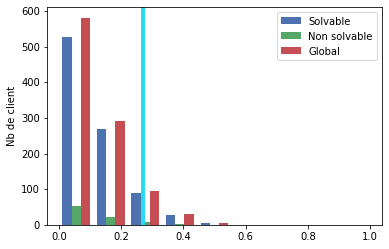

FLAG_OWN_CAR_N


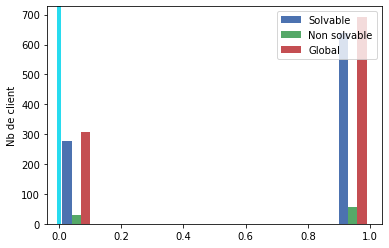

Comparaison des infos du client pour les features diminuant le risque
EXT_SOURCE_2


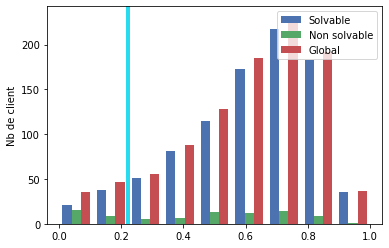

EXT_SOURCE_3


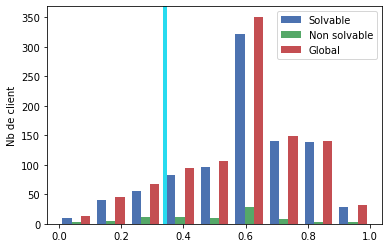

In [ ]:
hist_plot_global(407405,set_shap,pred_frame_dash_s1000)

## Comparaison proche voisin

In [ ]:
def comparaison_client_voisin(ID,frame_shap,frame_True,frame_hist):
  
  
  frame_shap['AGE']=round(frame_shap['DAYS_BIRTH'],1)
  frame_True['AGE']=round(abs(frame_True['DAYS_BIRTH']/365)).astype(int)
  
  ID_c=int(ID)

  #INFO CLIENT SHAP
  info_client=frame_shap[frame_shap['SK_ID_CURR']==ID_c]
  enfant_c=info_client['CNT_CHILDREN'].item()
  age_c=info_client['AGE'].item()
  genre_c=info_client['CODE_GENDER_M'].item()
  region_c=info_client['REGION_RATING_CLIENT'].item()
  
  #INFO CLIENT True
  info_client_t=frame_True[frame_True['SK_ID_CURR']==ID_c]
  enfant_c_t=info_client_t['CNT_CHILDREN'].item()
  age_c_t=info_client_t['AGE'].item()
  genre_c_t=info_client_t['CODE_GENDER'].item()
  region_c_t=info_client_t['REGION_RATING_CLIENT'].item()
  arr_cl=[]
  arr_cl.append(ID_c)
  arr_cl.append(age_c_t)
  arr_cl.append(genre_c_t)
  arr_cl.append(enfant_c_t)
  arr_cl.append(region_c_t)
  frame_info_client=pd.DataFrame(arr_cl)
  frame_info_client=frame_info_client.T
  frame_info_client.columns=['SK_ID_CURR','AGE','CODE_GENDER','CNT_CHILDREN','REGION_RATING_CLIENT']
  
  #PROCHE VOISIN
  enfant_v=frame_shap[frame_shap['CNT_CHILDREN']==enfant_c]
  age_v=enfant_v[enfant_v['AGE']==age_c]
  genre_v=age_v[age_v['CODE_GENDER_M']==genre_c]
  region_v=genre_v[genre_v['REGION_RATING_CLIENT']==region_c]

  if len(region_v) < 15:
    set_client_voisin=region_v.sample(len(region_v),random_state=42)
  if len(region_v) >= 15:
    set_client_voisin=region_v.sample(15,random_state=42)

  plt.barh(range(len(set_client_voisin)),set_client_voisin['Proba'])
  risque_client=info_client['Proba'].item()
  plt.axvline(x=risque_client,linewidth=8, color='#d62728')
  plt.xlabel('% de risque')
  plt.ylabel('Profils similaires')
  plt.show()

  moy_vois=set_client_voisin['Proba'].mean()
  diff_proba=round(abs(risque_client-moy_vois)*100,2)
  print('Le client',str(ID_c),'à un écart de',str(diff_proba),'% avec les clients de profils similaires')
  
  hist_plot_global(ID_c,frame_hist,set_client_voisin)

  return frame_info_client

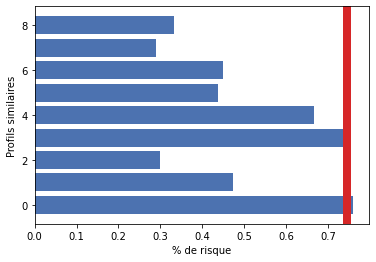

Le client 407405 à un écart de 25.01 % avec les clients de profils similaires
Comparaison des infos du client pour les features augmentant le risque
AMT_GOODS_PRICE


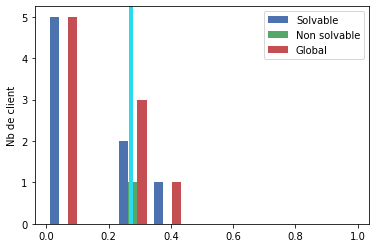

FLAG_OWN_CAR_N


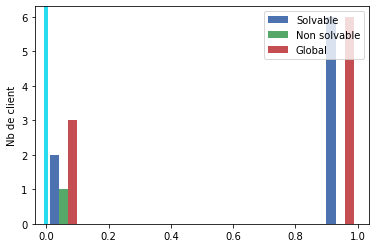

Comparaison des infos du client pour les features diminuant le risque
EXT_SOURCE_2


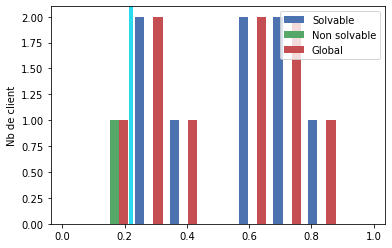

EXT_SOURCE_3


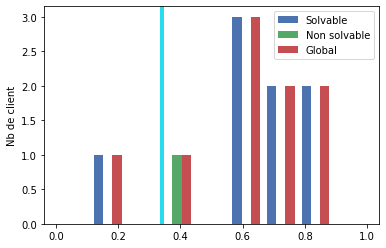

,SK_ID_CURR,AGE,CODE_GENDER,CNT_CHILDREN,REGION_RATING_CLIENT
0,407405,44,M,1,2


In [ ]:
set_client_voisin_407405=comparaison_client_voisin(407405, pred_frame_dash_s1000,set_tru_data,set_shap)
set_client_voisin_407405